In [1]:
!pip install pytorch_msssim
import os
import glob
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image as PILImage
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from google.colab import drive
from pytorch_msssim import SSIM
import matplotlib.pyplot as plt
import random
import shutil
from IPython.display import Image, display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [2]:
# Install dependencies
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121
!pip install pytorch-msssim scikit-image matplotlib
!apt-get install -y ffmpeg

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.0/781.0 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Copy dataset to local disk
local_base_path = '/content/FER'
gdrive_base_path = '/content/drive/MyDrive/FER'
if not os.path.exists(local_base_path):
    print("📂 Copying dataset to local disk...")
    start_time = time.time()
    shutil.copytree(gdrive_base_path, local_base_path)
    print(f"✅ Dataset copied to {local_base_path} in {time.time() - start_time:.2f} seconds")

📂 Copying dataset to local disk...
✅ Dataset copied to /content/FER in 347.08 seconds


In [7]:
# Define dataset paths
splits = {
    'train': os.path.join(local_base_path, 'Train'),
    'validate': os.path.join(local_base_path, 'Validate'),
    'test': os.path.join(local_base_path, 'Test')
}
sigma = 15
image_size = (48, 48)
output_dir = '/content/drive/MyDrive/denoising_samples'
drive_checkpoint_dir = '/content/drive/MyDrive/bimsaae_checkpoints'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(drive_checkpoint_dir, exist_ok=True)

In [8]:
# Verify folder existence and image sizes
for split, path in splits.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Folder not found: {path}")
    noisy_path = os.path.join(path, f'noisy_sigma{sigma}')
    if not os.path.exists(noisy_path):
        raise FileNotFoundError(f"Noisy folder not found: {noisy_path}")
    print(f"📂 Found {split} folder: {path}")
    sample_files = glob.glob(os.path.join(noisy_path, '*.jpg'))
    if sample_files:
        sample_img = PILImage.open(sample_files[0]).convert('L')
        if sample_img.size != image_size:
            raise ValueError(f"Expected 128x128 images, found {sample_img.size} in {noisy_path}")

📂 Found train folder: /content/FER/Train
📂 Found validate folder: /content/FER/Validate
📂 Found test folder: /content/FER/Test


In [9]:
# Dataset class for grayscale JPG
class PairedNoisyCleanDataset(Dataset):
    def __init__(self, base_dir, split, transform=None):
        self.transform = transform
        split_dir = os.path.join(base_dir, split.capitalize())
        noisy_dir = os.path.join(split_dir, f'noisy_sigma{sigma}')
        self.clean_images = []
        for root, _, files in os.walk(split_dir):
            if os.path.abspath(root) == os.path.abspath(noisy_dir):
                continue
            for f in files:
                if f.lower().endswith('.jpg'):
                    self.clean_images.append(os.path.join(root, f))
        self.noisy_images = [
            os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir)
            if f.lower().endswith('.jpg')
        ]
        clean_dict = {os.path.basename(p): p for p in self.clean_images}
        noisy_dict = {os.path.basename(p): p for p in self.noisy_images}
        self.matched_clean = []
        self.matched_noisy = []
        for fname in noisy_dict:
            if fname in clean_dict:
                self.matched_clean.append(clean_dict[fname])
                self.matched_noisy.append(noisy_dict[fname])
        print(f"📊 [{split}] Found {len(self.matched_clean)} paired samples")

    def __len__(self):
        return len(self.matched_clean)

    def __getitem__(self, idx):
        noisy_img = PILImage.open(self.matched_noisy[idx]).convert('L')
        clean_img = PILImage.open(self.matched_clean[idx]).convert('L')
        if self.transform:
            seed = torch.randint(0, 2**31, (1,)).item()
            torch.manual_seed(seed)
            noisy_img = self.transform(noisy_img)
            torch.manual_seed(seed)
            clean_img = self.transform(clean_img)
        return noisy_img, clean_img, self.matched_noisy[idx]

# Transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(48),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])
val_test_transform = transforms.ToTensor()

In [11]:
# Datasets and DataLoaders
batch_size = 16
train_dataset = PairedNoisyCleanDataset(local_base_path, 'train', train_transform)
val_dataset = PairedNoisyCleanDataset(local_base_path, 'validate', val_test_transform)
test_dataset = PairedNoisyCleanDataset(local_base_path, 'test', val_test_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

📊 [train] Found 8528 paired samples
📊 [validate] Found 2658 paired samples
📊 [test] Found 2148 paired samples
Train dataset size: 8528
Validation dataset size: 2658
Test dataset size: 2148


In [12]:
# Bi-MSAAE Model for grayscale
class MultiScaleEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(1, 126, kernel_size=3, padding=1),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 126, kernel_size=3, padding=1),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True)
        )
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(1, 126, kernel_size=5, padding=2),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 126, kernel_size=5, padding=2),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True)
        )
        self.residual = nn.Conv2d(1, 252, kernel_size=1)

    def forward(self, x):
        f1 = self.branch3x3(x)
        f2 = self.branch5x5(x)
        res = self.residual(x)
        return torch.cat([f1, f2], dim=1) + res

class NoiseGateModule(nn.Module):
    def __init__(self, in_channels=252):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        mask = self.conv(x)
        mask = self.sigmoid(mask)
        return x * mask

class ChannelAttentionBlock(nn.Module):
    def __init__(self, in_channels=252):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.conv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.avg_pool(x)
        max_out = self.max_pool(x)
        pooled = torch.cat([avg_out, max_out], dim=1)
        attn = self.conv(pooled)
        attn = self.sigmoid(attn)
        return x * attn

class DualHeadDecoder(nn.Module):
    def __init__(self, in_channels=252):
        super().__init__()
        self.structural_head = nn.Sequential(
            nn.Conv2d(in_channels, 126, kernel_size=3, padding=1),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 63, kernel_size=3, padding=1),
            nn.BatchNorm2d(63),
            nn.ReLU(inplace=True),
            nn.Conv2d(63, 33, kernel_size=3, padding=1),
            nn.BatchNorm2d(33),
            nn.ReLU(inplace=True),
            nn.Conv2d(33, 15, kernel_size=3, padding=1),
            nn.BatchNorm2d(15),
            nn.ReLU(inplace=True),
            nn.Conv2d(15, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )
        self.texture_head = nn.Sequential(
            nn.Conv2d(in_channels, 126, kernel_size=5, padding=2),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 63, kernel_size=5, padding=2),
            nn.BatchNorm2d(63),
            nn.ReLU(inplace=True),
            nn.Conv2d(63, 33, kernel_size=5, padding=2),
            nn.BatchNorm2d(33),
            nn.ReLU(inplace=True),
            nn.Conv2d(33, 15, kernel_size=5, padding=2),
            nn.BatchNorm2d(15),
            nn.ReLU(inplace=True),
            nn.Conv2d(15, 1, kernel_size=5, padding=2),
            nn.BatchNorm2d(1)
        )
        self.alpha = nn.Parameter(torch.tensor(0.6))

    def forward(self, x):
        struct = self.structural_head(x)
        text = self.texture_head(x)
        return self.alpha * struct + (1 - self.alpha) * text

class SharpeningModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        laplacian = torch.tensor([[[[0, -1, 0], [-1, 4, -1], [0, -1, 0]]]], dtype=torch.float32)
        self.conv.weight = nn.Parameter(laplacian)
        self.strength = nn.Parameter(torch.tensor(0.7))

    def forward(self, x):
        edges = self.conv(x)
        return x + self.strength * edges

class BiMSAAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = MultiScaleEncoder()
        self.noise_gate = NoiseGateModule()
        self.attention = ChannelAttentionBlock()
        self.decoder = DualHeadDecoder()
        self.sharpen = SharpeningModule()
        self.skip_conv = nn.Conv2d(252, 252, kernel_size=1)

    def forward(self, x):
        f = self.encoder(x)
        skip = self.skip_conv(f)
        f = self.noise_gate(f)
        f = self.attention(f)
        f = f + skip
        out = self.decoder(f)
        out = torch.sigmoid(out)
        out = self.sharpen(out)
        return torch.clamp(out, 0, 1)

In [13]:
# Loss Functions
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features[:9].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.to(dtype=torch.float32)
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        output = output.repeat(1, 3, 1, 1).to(dtype=torch.float32)
        target = target.repeat(1, 3, 1, 1).to(dtype=torch.float32)
        output_vgg = self.vgg(output)
        target_vgg = self.vgg(target)
        return self.mse(output_vgg, target_vgg)

class EdgeLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.sobel_x = torch.tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]], dtype=torch.float32)
        self.sobel_y = torch.tensor([[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]], dtype=torch.float32)
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        self.sobel_x = self.sobel_x.to(output.device)
        self.sobel_y = self.sobel_y.to(output.device)
        grad_x_out = F.conv2d(output, self.sobel_x)
        grad_y_out = F.conv2d(output, self.sobel_y)
        grad_x_tgt = F.conv2d(target, self.sobel_x)
        grad_y_tgt = F.conv2d(target, self.sobel_y)
        return self.mse(grad_x_out, grad_x_tgt) + self.mse(grad_y_out, grad_y_tgt)


In [14]:
# Training function
def train_model(model, train_loader, val_loader, mse_criterion, perceptual_criterion, ssim_criterion, edge_criterion, optimizer, scheduler, device, num_epochs, warmup_epochs=5, start_epoch=0):
    model.to(device)
    best_psnr = 0.0
    best_model_path = os.path.join(drive_checkpoint_dir, 'bimsaae_best.pth')
    for epoch in range(start_epoch, num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0
        lr = optimizer.param_groups[0]['lr']
        if epoch < warmup_epochs:
            lr_factor = (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * lr_factor
        optimizer.zero_grad()
        for noisy, clean, _ in train_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            outputs = model(noisy)
            mse_loss = mse_criterion(outputs, clean)
            perceptual_loss = perceptual_criterion(outputs, clean)
            ssim_loss = 1 - ssim_criterion(outputs, clean)
            edge_loss = edge_criterion(outputs, clean)
            loss = 0.5 * mse_loss + 0.3 * perceptual_loss + 0.1 * ssim_loss + 0.1 * edge_loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item() * noisy.size(0)
        model.eval()
        val_loss, psnr_val, ssim_val = 0.0, 0.0, 0.0
        with torch.no_grad():
            for noisy, clean, _ in val_loader:
                noisy, clean = noisy.to(device), clean.to(device)
                outputs = model(noisy)
                mse_loss = mse_criterion(outputs, clean)
                perceptual_loss = perceptual_criterion(outputs, clean)
                ssim_loss = 1 - ssim_criterion(outputs, clean)
                edge_loss = edge_criterion(outputs, clean)
                loss = 0.5 * mse_loss + 0.3 * perceptual_loss + 0.1 * ssim_loss + 0.1 * edge_loss
                val_loss += loss.item() * noisy.size(0)
                outputs_np = outputs.cpu().numpy()
                clean_np = clean.cpu().numpy()
                for i in range(outputs_np.shape[0]):
                    psnr_val += peak_signal_noise_ratio(clean_np[i, 0], outputs_np[i, 0], data_range=1.0)
                    ssim_val += structural_similarity(clean_np[i, 0], outputs_np[i, 0], data_range=1.0, win_size=7)
        val_loss /= len(val_dataset)
        psnr_val /= len(val_dataset)
        ssim_val /= len(val_dataset)
        avg_train_loss = train_loss / len(train_dataset)
        epoch_time = time.time() - start_time
        current_lr = optimizer.param_groups[0]['lr']
        if epoch >= warmup_epochs:
            scheduler.step()
        print(f"\r\033[96mEpoch {epoch+1}/{num_epochs} [{100*(epoch+1)/num_epochs:.1f}%]\033[0m")
        print(f"🌟 Train Loss: {avg_train_loss:.6f} | Val Loss: {val_loss:.6f} | PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f} | Time: {epoch_time:.2f}s | LR: {current_lr:.6e}")
        checkpoint_path = os.path.join(drive_checkpoint_dir, f'bimsaae_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), checkpoint_path)
        print(f"💾 Checkpoint saved to {checkpoint_path}")
        if psnr_val > best_psnr:
            best_psnr = psnr_val
            torch.save(model.state_dict(), best_model_path)
            print(f"🏆 New best model saved to {best_model_path} (PSNR: {psnr_val:.2f})")
        if psnr_val > 35 and ssim_val > 0.95 and epoch >= 20:
            print(f"🎯 Target metrics achieved at epoch {epoch+1}. Stopping training.")
            break


In [15]:
# Device and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiMSAAE().to(device)
mse_criterion = nn.MSELoss()
perceptual_criterion = PerceptualLoss().to(device)
ssim_criterion = SSIM(data_range=1.0, channel=1, win_size=7).to(device)
edge_criterion = EdgeLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=95)
num_epochs = 100

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 187MB/s]


In [17]:
# Train model
train_model(model, train_loader, val_loader, mse_criterion, perceptual_criterion, ssim_criterion, edge_criterion, optimizer, scheduler, device, num_epochs, start_epoch=start_epoch)

Epoch 1/100 [1.0%]
🌟 Train Loss: 0.149221 | Val Loss: 0.101334 | PSNR: 23.57 dB | SSIM: 0.8871 | Time: 14.51s | LR: 6.000000e-05
💾 Checkpoint saved to /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_1.pth
🏆 New best model saved to /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_best.pth (PSNR: 23.57)
Epoch 2/100 [2.0%]
🌟 Train Loss: 0.100905 | Val Loss: 0.095361 | PSNR: 25.20 dB | SSIM: 0.8967 | Time: 13.13s | LR: 2.400000e-05
💾 Checkpoint saved to /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_2.pth
🏆 New best model saved to /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_best.pth (PSNR: 25.20)
Epoch 3/100 [3.0%]
🌟 Train Loss: 0.097934 | Val Loss: 0.095019 | PSNR: 24.50 dB | SSIM: 0.8942 | Time: 12.97s | LR: 1.440000e-05
💾 Checkpoint saved to /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_3.pth
Epoch 4/100 [4.0%]
🌟 Train Loss: 0.095689 | Val Loss: 0.094921 | PSNR: 23.51 dB | SSIM: 0.8894 | Time: 13.45s | LR: 1.152000e-05
💾 Checkpoint saved to /conten

In [20]:
# Save final model
final_model_path = os.path.join(drive_checkpoint_dir, 'bimsaae_final.pth')
torch.save(model.state_dict(), final_model_path)
print(f"✅ Training complete. Final model saved to: {final_model_path}")

✅ Training complete. Final model saved to: /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_final.pth


In [23]:
# Resume from latest checkpoint
checkpoint_paths = sorted(glob.glob(os.path.join(drive_checkpoint_dir, 'bimsaae_epoch_*.pth')))
start_epoch = 99
if checkpoint_paths:
    latest_checkpoint = checkpoint_paths[-1]
    print(f"📂 Resuming from checkpoint: {latest_checkpoint}")
    model.load_state_dict(torch.load(latest_checkpoint, map_location=device))
    epoch_num = int(latest_checkpoint.split('_')[-1].split('.')[0])
    if epoch_num != start_epoch:
        print(f"Warning: Expected checkpoint for epoch 100, found epoch {epoch_num}")
    # Fast-forward scheduler to epoch 100
    for _ in range(start_epoch):
        scheduler.step()
else:
    final_checkpoint = os.path.join(drive_checkpoint_dir, 'bimsaae_final.pth')
    if os.path.exists(final_checkpoint):
        print(f"📂 Resuming from final checkpoint: {final_checkpoint}")
        model.load_state_dict(torch.load(final_checkpoint, map_location=device))
    else:
        raise FileNotFoundError("No checkpoint or final model found in {drive_checkpoint_dir}")

📂 Resuming from checkpoint: /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_99.pth


In [24]:
# Continue training from epoch 101 to 200
num_epochs = 200
train_model(model, train_loader, val_loader, mse_criterion, perceptual_criterion, ssim_criterion, edge_criterion, optimizer, scheduler, device, num_epochs, start_epoch=start_epoch)

Epoch 100/200 [50.0%]
🌟 Train Loss: 0.079101 | Val Loss: 0.077563 | PSNR: 28.40 dB | SSIM: 0.9212 | Time: 12.87s | LR: 6.594633e-06
💾 Checkpoint saved to /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_100.pth
🏆 New best model saved to /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_best.pth (PSNR: 28.40)
Epoch 101/200 [50.5%]
🌟 Train Loss: 0.079068 | Val Loss: 0.077460 | PSNR: 28.58 dB | SSIM: 0.9222 | Time: 13.24s | LR: 8.127414e-06
💾 Checkpoint saved to /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_101.pth
🏆 New best model saved to /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_best.pth (PSNR: 28.58)
Epoch 102/200 [51.0%]
🌟 Train Loss: 0.079162 | Val Loss: 0.077389 | PSNR: 28.54 dB | SSIM: 0.9219 | Time: 12.97s | LR: 9.815330e-06
💾 Checkpoint saved to /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_102.pth
Epoch 103/200 [51.5%]
🌟 Train Loss: 0.078927 | Val Loss: 0.077290 | PSNR: 28.71 dB | SSIM: 0.9223 | Time: 13.11s | LR: 1.165654e-05
💾 Checkpoin

In [33]:
# Save final model
final_model_path = os.path.join(drive_checkpoint_dir, 'bimsaae_final.pth')
torch.save(model.state_dict(), final_model_path)
print(f"✅ Training complete. Final model saved to: {final_model_path}")

✅ Training complete. Final model saved to: /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_final.pth


In [35]:
# Test evaluation and visualization
model.eval()
test_loss, inference_times = 0.0, []
psnr_noisy_clean, psnr_noisy_denoised, psnr_clean_denoised = [], [], []
ssim_noisy_clean, ssim_noisy_denoised, ssim_clean_denoised = [], [], []
sample_images = []
num_samples = 5



Displaying Sample 1 (PublicTest_55659919.jpg)


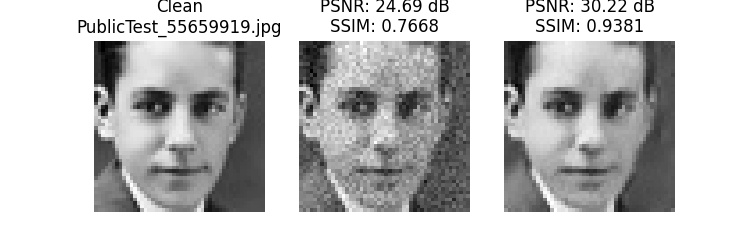


Displaying Sample 2 (PublicTest_35874394.jpg)


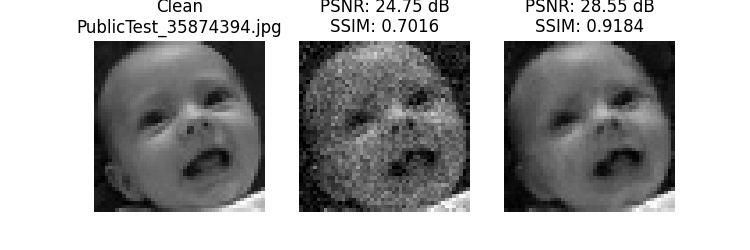


Displaying Sample 3 (PublicTest_35884954.jpg)


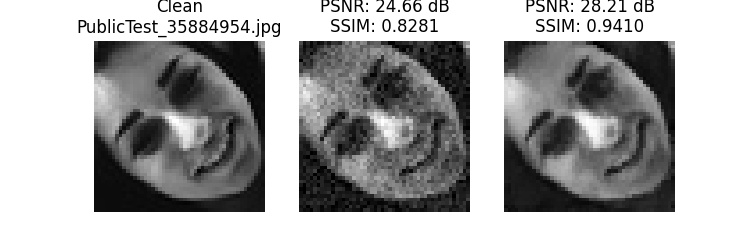


Displaying Sample 4 (PublicTest_53850550.jpg)


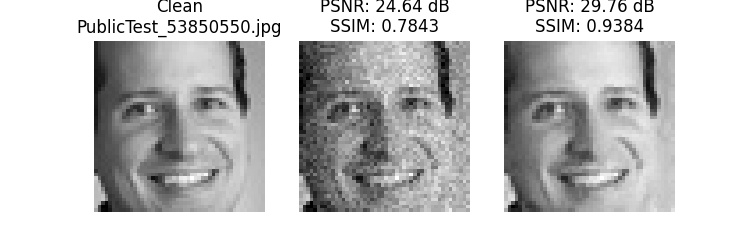


Displaying Sample 5 (PublicTest_25530597.jpg)


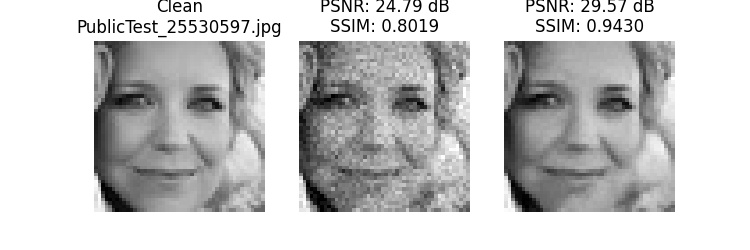

In [40]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from IPython.display import display, Image

# Initialize lists before loop
inference_times = []
sample_images = []
psnr_noisy_clean = []
psnr_noisy_denoised = []
psnr_clean_denoised = []
ssim_noisy_clean = []
ssim_noisy_denoised = []
ssim_clean_denoised = []
test_loss = 0.0

num_samples = 5  # number of samples to test
output_dir = './output_samples'
os.makedirs(output_dir, exist_ok=True)

# Assuming test_dataset, model, mse_criterion, perceptual_criterion,
# ssim_criterion, edge_criterion, device are already defined

with torch.no_grad():
    test_samples = random.sample(list(test_dataset), min(num_samples, len(test_dataset)))
    for idx, (noisy, clean, noisy_path) in enumerate(test_samples):
        noisy, clean = noisy.unsqueeze(0).to(device), clean.unsqueeze(0).to(device)
        start_time = time.time()
        denoised = model(noisy)
        inference_times.append((time.time() - start_time) * 1000)  # ms

        # Compute losses
        mse_loss = mse_criterion(denoised, clean)
        perceptual_loss = perceptual_criterion(denoised, clean)
        ssim_loss = 1 - ssim_criterion(denoised, clean)
        edge_loss = edge_criterion(denoised, clean)
        loss = 0.5 * mse_loss + 0.3 * perceptual_loss + 0.1 * ssim_loss + 0.1 * edge_loss
        test_loss += loss.item()

        # Convert tensors to numpy arrays and clip
        noisy_np = np.clip(noisy.cpu().numpy()[0, 0], 0, 1).astype(np.float32)
        clean_np = np.clip(clean.cpu().numpy()[0, 0], 0, 1).astype(np.float32)
        denoised_np = np.clip(denoised.cpu().numpy()[0, 0], 0, 1).astype(np.float32)

        sample_images.append((clean_np, noisy_np, denoised_np, os.path.basename(noisy_path)))

        # Calculate PSNR and SSIM
        psnr_nc = peak_signal_noise_ratio(clean_np, noisy_np, data_range=1.0)
        psnr_nd = peak_signal_noise_ratio(noisy_np, denoised_np, data_range=1.0)
        psnr_cd = peak_signal_noise_ratio(clean_np, denoised_np, data_range=1.0)

        ssim_nc = structural_similarity(clean_np, noisy_np, data_range=1.0, win_size=7)
        ssim_nd = structural_similarity(noisy_np, denoised_np, data_range=1.0, win_size=7)
        ssim_cd = structural_similarity(clean_np, denoised_np, data_range=1.0, win_size=7)

        psnr_noisy_clean.append(psnr_nc)
        psnr_noisy_denoised.append(psnr_nd)
        psnr_clean_denoised.append(psnr_cd)
        ssim_noisy_clean.append(ssim_nc)
        ssim_noisy_denoised.append(ssim_nd)
        ssim_clean_denoised.append(ssim_cd)

        # Plot the images smaller size (7.5 x 2.5 inches)
        fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))

        axes[0].imshow(clean_np, cmap='gray')
        axes[0].set_title(f"Clean\n{os.path.basename(noisy_path)}")
        axes[0].axis('off')

        axes[1].imshow(noisy_np, cmap='gray')
        axes[1].set_title(f"Noisy\nPSNR: {psnr_nc:.2f} dB\nSSIM: {ssim_nc:.4f}")
        axes[1].axis('off')

        axes[2].imshow(denoised_np, cmap='gray')
        axes[2].set_title(f"Denoised\nPSNR: {psnr_cd:.2f} dB\nSSIM: {ssim_cd:.4f}")
        axes[2].axis('off')

        # Save the figure using canvas.print_to_buffer()
        canvas = FigureCanvas(fig)
        canvas.draw()
        buf, (w, h) = canvas.print_to_buffer()
        img = np.frombuffer(buf, dtype=np.uint8).reshape(h, w, 4)  # RGBA
        img = img[:, :, :3]  # drop alpha channel (RGBA -> RGB)
        pil_img = PILImage.fromarray(img)
        sample_path = os.path.join(output_dir, f'sample_{idx+1}.jpg')
        pil_img.save(sample_path, quality=95)

        plt.close(fig)

        print(f"\nDisplaying Sample {idx+1} ({os.path.basename(noisy_path)})")
        display(Image(filename=sample_path))

In [41]:
# Print metrics
print(f"📊 Test Results: Loss: {test_loss/len(test_samples):.6f} | Inference Time: {sum(inference_times)/len(inference_times):.2f} ms")
print("\nSample Metrics:")
for i, fname in enumerate([f[3] for f in sample_images]):
    print(f"\nSample {i+1} ({fname}):")
    print(f"  Noisy vs Clean: PSNR: {psnr_noisy_clean[i]:.2f} dB, SSIM: {ssim_noisy_clean[i]:.4f}")
    print(f"  Noisy vs Denoised: PSNR: {psnr_noisy_denoised[i]:.2f} dB, SSIM: {ssim_noisy_denoised[i]:.4f}")
    print(f"  Clean vs Denoised: PSNR: {psnr_clean_denoised[i]:.2f} dB, SSIM: {ssim_clean_denoised[i]:.4f}")
print(f"\n📸 Sample images and plots saved to {output_dir}")

📊 Test Results: Loss: 0.071960 | Inference Time: 4.62 ms

Sample Metrics:

Sample 1 (PublicTest_55659919.jpg):
  Noisy vs Clean: PSNR: 24.69 dB, SSIM: 0.7668
  Noisy vs Denoised: PSNR: 26.43 dB, SSIM: 0.8308
  Clean vs Denoised: PSNR: 30.22 dB, SSIM: 0.9381

Sample 2 (PublicTest_35874394.jpg):
  Noisy vs Clean: PSNR: 24.75 dB, SSIM: 0.7016
  Noisy vs Denoised: PSNR: 25.22 dB, SSIM: 0.7694
  Clean vs Denoised: PSNR: 28.55 dB, SSIM: 0.9184

Sample 3 (PublicTest_35884954.jpg):
  Noisy vs Clean: PSNR: 24.66 dB, SSIM: 0.8281
  Noisy vs Denoised: PSNR: 25.94 dB, SSIM: 0.8869
  Clean vs Denoised: PSNR: 28.21 dB, SSIM: 0.9410

Sample 4 (PublicTest_53850550.jpg):
  Noisy vs Clean: PSNR: 24.64 dB, SSIM: 0.7843
  Noisy vs Denoised: PSNR: 26.38 dB, SSIM: 0.8444
  Clean vs Denoised: PSNR: 29.76 dB, SSIM: 0.9384

Sample 5 (PublicTest_25530597.jpg):
  Noisy vs Clean: PSNR: 24.79 dB, SSIM: 0.8019
  Noisy vs Denoised: PSNR: 26.68 dB, SSIM: 0.8641
  Clean vs Denoised: PSNR: 29.57 dB, SSIM: 0.9430

📸 Sam

In [47]:
# Evaluate
model.eval()
test_loss, inference_times = 0.0, []
test_psnr_noisy_clean, test_psnr_noisy_denoised, test_psnr_clean_denoised = 0.0, 0.0, 0.0
test_ssim_noisy_clean, test_ssim_noisy_denoised, test_ssim_clean_denoised = 0.0, 0.0, 0.0
total_samples = 0
psnr_noisy_clean, psnr_noisy_denoised, psnr_clean_denoised = [], [], []
ssim_noisy_clean, ssim_noisy_denoised, ssim_clean_denoised = [], [], []
sample_images = []
num_samples = 5

In [48]:
# Entire test set
with torch.no_grad():
    for noisy, clean, _ in test_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        start_time = time.time()
        denoised = model(noisy)
        inference_times.append((time.time() - start_time) * 1000 / noisy.size(0))
        mse_loss = mse_criterion(denoised, clean)
        perceptual_loss = perceptual_criterion(denoised, clean)
        ssim_loss = 1 - ssim_criterion(denoised, clean)
        edge_loss = edge_criterion(denoised, clean)
        loss = 0.5 * mse_loss + 0.3 * perceptual_loss + 0.1 * ssim_loss + 0.1 * edge_loss
        test_loss += loss.item() * noisy.size(0)
        noisy_np = noisy.cpu().numpy()
        clean_np = clean.cpu().numpy()
        denoised_np = denoised.cpu().numpy()
        for i in range(noisy_np.shape[0]):
            nc = peak_signal_noise_ratio(clean_np[i, 0], noisy_np[i, 0], data_range=1.0)
            nd = peak_signal_noise_ratio(noisy_np[i, 0], denoised_np[i, 0], data_range=1.0)
            cd = peak_signal_noise_ratio(clean_np[i, 0], denoised_np[i, 0], data_range=1.0)
            s_nc = structural_similarity(clean_np[i, 0], noisy_np[i, 0], data_range=1.0, win_size=7)
            s_nd = structural_similarity(noisy_np[i, 0], denoised_np[i, 0], data_range=1.0, win_size=7)
            s_cd = structural_similarity(clean_np[i, 0], denoised_np[i, 0], data_range=1.0, win_size=7)
            test_psnr_noisy_clean += nc
            test_psnr_noisy_denoised += nd
            test_psnr_clean_denoised += cd
            test_ssim_noisy_clean += s_nc
            test_ssim_noisy_denoised += s_nd
            test_ssim_clean_denoised += s_cd
            total_samples += 1

In [49]:
# 5 random samples
with torch.no_grad():
    test_samples = random.sample(list(test_dataset), min(num_samples, len(test_dataset)))
    for idx, (noisy, clean, noisy_path) in enumerate(test_samples):
        noisy, clean = noisy.unsqueeze(0).to(device), clean.unsqueeze(0).to(device)
        denoised = model(noisy)
        noisy_np = noisy.cpu().numpy()[0, 0]
        clean_np = clean.cpu().numpy()[0, 0]
        denoised_np = denoised.cpu().numpy()[0, 0]
        noisy_np = np.clip(noisy_np, 0, 1).astype(np.float32)
        clean_np = np.clip(clean_np, 0, 1).astype(np.float32)
        denoised_np = np.clip(denoised_np, 0, 1).astype(np.float32)
        sample_images.append((clean_np, noisy_np, denoised_np, os.path.basename(noisy_path)))
        psnr_nc = peak_signal_noise_ratio(clean_np, noisy_np, data_range=1.0)
        psnr_nd = peak_signal_noise_ratio(noisy_np, denoised_np, data_range=1.0)
        psnr_cd = peak_signal_noise_ratio(clean_np, denoised_np, data_range=1.0)
        ssim_nc = structural_similarity(clean_np, noisy_np, data_range=1.0, win_size=7)
        ssim_nd = structural_similarity(noisy_np, denoised_np, data_range=1.0, win_size=7)
        ssim_cd = structural_similarity(clean_np, denoised_np, data_range=1.0, win_size=7)
        psnr_noisy_clean.append(psnr_nc)
        psnr_noisy_denoised.append(psnr_nd)
        psnr_clean_denoised.append(psnr_cd)
        ssim_noisy_clean.append(ssim_nc)
        ssim_noisy_denoised.append(ssim_nd)
        ssim_clean_denoised.append(ssim_cd)

In [50]:
# Print results
test_loss /= len(test_dataset)
test_psnr_noisy_clean /= total_samples
test_psnr_noisy_denoised /= total_samples
test_psnr_clean_denoised /= total_samples
test_ssim_noisy_clean /= total_samples
test_ssim_noisy_denoised /= total_samples
test_ssim_clean_denoised /= total_samples

print(f"\n📊 Test Results (Entire Test Set, {total_samples} samples):")
print(f"  Loss: {test_loss:.6f}")
print(f"  Average Inference Time: {sum(inference_times)/len(inference_times):.2f} ms")
print(f"  Average PSNR - Noisy vs Clean: {test_psnr_noisy_clean:.2f} dB")
print(f"  Average PSNR - Noisy vs Denoised: {test_psnr_noisy_denoised:.2f} dB")
print(f"  Average PSNR - Clean vs Denoised: {test_psnr_clean_denoised:.2f} dB")
print(f"  Average SSIM - Noisy vs Clean Vanderbijlpark {test_ssim_noisy_clean:.4f}")
print(f"  Average SSIM - Noisy vs Denoised: {test_ssim_noisy_denoised:.4f}")
print(f"  Average SSIM - Clean vs Denoised: {test_ssim_clean_denoised:.4f}")

print("\nSample Metrics (5 Random Samples):")
for i, fname in enumerate([f[3] for f in sample_images]):
    print(f"\nSample {i+1} ({fname}):")
    print(f"  Noisy vs Clean: PSNR: {psnr_noisy_clean[i]:.2f} dB, SSIM: {ssim_noisy_clean[i]:.4f}")
    print(f"  Noisy vs Denoised: PSNR: {psnr_noisy_denoised[i]:.2f} dB, SSIM: {ssim_noisy_denoised[i]:.4f}")
    print(f"  Clean vs Denoised: PSNR: {psnr_clean_denoised[i]:.2f} dB, SSIM: {ssim_clean_denoised[i]:.4f}")
print(f"\n📸 Sample images and plots saved to {output_dir}")


📊 Test Results (Entire Test Set, 2148 samples):
  Loss: 0.078686
  Average Inference Time: 0.30 ms
  Average PSNR - Noisy vs Clean: 24.79 dB
  Average PSNR - Noisy vs Denoised: 26.28 dB
  Average PSNR - Clean vs Denoised: 28.57 dB
  Average SSIM - Noisy vs Clean Vanderbijlpark 0.7909
  Average SSIM - Noisy vs Denoised: 0.8443
  Average SSIM - Clean vs Denoised: 0.9243

Sample Metrics (5 Random Samples):

Sample 1 (PublicTest_35775434.jpg):
  Noisy vs Clean: PSNR: 24.50 dB, SSIM: 0.8359
  Noisy vs Denoised: PSNR: 26.49 dB, SSIM: 0.8848
  Clean vs Denoised: PSNR: 28.34 dB, SSIM: 0.9306

Sample 2 (PublicTest_88733920.jpg):
  Noisy vs Clean: PSNR: 24.89 dB, SSIM: 0.7339
  Noisy vs Denoised: PSNR: 25.24 dB, SSIM: 0.7962
  Clean vs Denoised: PSNR: 27.66 dB, SSIM: 0.9255

Sample 3 (PublicTest_55239463.jpg):
  Noisy vs Clean: PSNR: 24.62 dB, SSIM: 0.7920
  Noisy vs Denoised: PSNR: 26.52 dB, SSIM: 0.8458
  Clean vs Denoised: PSNR: 29.97 dB, SSIM: 0.9370

Sample 4 (PublicTest_59544229.jpg):
  N